In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/deep_fake_updated.zip" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Train/Real/real_66215.jpg  
  inflating: /content/dataset/Train/Real/real_40149.jpg  
  inflating: /content/dataset/Train/Real/real_43795.jpg  
  inflating: /content/dataset/Train/Real/real_35700.jpg  
  inflating: /content/dataset/Train/Real/real_5108.jpg  
  inflating: /content/dataset/Train/Real/real_47979.jpg  
  inflating: /content/dataset/Train/Real/real_43904.jpg  
  inflating: /content/dataset/Train/Real/real_8005.jpg  
  inflating: /content/dataset/Train/Real/real_17112.jpg  
  inflating: /content/dataset/Train/Real/real_3224.jpg  
  inflating: /content/dataset/Train/Real/real_20264.jpg  
  inflating: /content/dataset/Train/Real/real_48452.jpg  
  inflating: /content/dataset/Train/Real/real_22410.jpg  
  inflating: /content/dataset/Train/Real/real_16048.jpg  
  inflating: /content/dataset/Train/Real/real_27798.jpg  
  inflating: /content/dataset/Train/Real/real_45611.jpg  
  inflating: /content/da

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Adjust for 2 classes (Fake/Real)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [4]:
import os

# Path to your dataset directory
dataset_path = "/content/dataset"

# Rename Validation folder to Val
old_folder = os.path.join(dataset_path, "Validation")
new_folder = os.path.join(dataset_path, "Val")

if os.path.exists(old_folder):
    os.rename(old_folder, new_folder)
    print("Folder renamed successfully!")
else:
    print("Folder 'Validation' not found.")


Folder renamed successfully!


In [5]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("/content/dataset/Train", transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder("/content/dataset/Val", transform=data_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/10, Loss: 0.18589864671230316
Epoch 2/10, Loss: 0.05553750693798065
Epoch 3/10, Loss: 0.0708417147397995
Epoch 4/10, Loss: 0.3350834548473358
Epoch 5/10, Loss: 0.0028562701772898436
Epoch 6/10, Loss: 0.007170549593865871
Epoch 7/10, Loss: 0.016740048304200172
Epoch 8/10, Loss: 0.07980316132307053
Epoch 9/10, Loss: 0.006569873541593552
Epoch 10/10, Loss: 0.017645325511693954


In [7]:
save_path = "/content/drive/My Drive/fake_real_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")


Model saved at /content/drive/My Drive/fake_real_model.pth


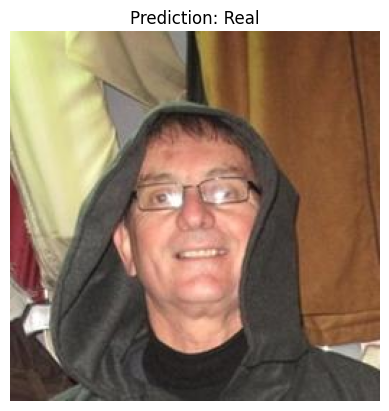

In [9]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load your trained model
model_path = "/content/drive/MyDrive/fake_real_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and load weights
from torchvision import models
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Ensure the output matches your classes
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Define transformations for the test image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess the test image
image_path = "/content/dataset/Train/Real/real_0.jpg"  # Change to a real test image path
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0).to(device)

# Perform Prediction
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Map prediction to label
class_names = ["Fake", "Real"]
predicted_label = class_names[predicted_class]

# Display the image with prediction
plt.imshow(image)
plt.title(f"Prediction: {predicted_label}")
plt.axis("off")
plt.show()


In [22]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=10a53e2bad579b724d19f2ec9f56030bcd5751f32b1bb9e78ce419687eecab05
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [23]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries


In [24]:
# Set device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pre-trained Model
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Adjust output for 2 classes (Fake/Real)
model.load_state_dict(torch.load("/content/drive/My Drive/fake_real_model.pth", map_location=device))
model = model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

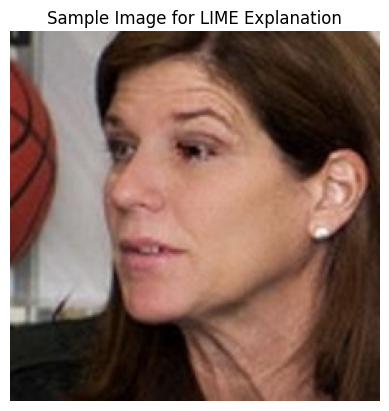

In [25]:
# Define Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load a Sample Image (Change path to an actual image)
image_path = "/content/dataset/Train/Fake/fake_10001.jpg"  # Change to your actual test image path
image = Image.open(image_path)

# Convert Image to Tensor
input_tensor = transform(image).unsqueeze(0).to(device)

# Convert Image to Numpy Array for LIME (H, W, C)
image_np = np.array(image.resize((224, 224)))

# Display the Sample Image
plt.imshow(image_np)
plt.title("Sample Image for LIME Explanation")
plt.axis("off")
plt.show()


In [26]:
# Function to make model compatible with LIME
def model_predict(image_batch):
    """Convert a batch of images to model predictions."""
    model.eval()
    image_batch = torch.tensor(image_batch, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert (B, H, W, C) → (B, C, H, W)
    image_batch = image_batch.to(device)

    with torch.no_grad():
        outputs = model(image_batch)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities

    return probs  # LIME requires probabilities

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(image_np, model_predict, top_labels=2, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

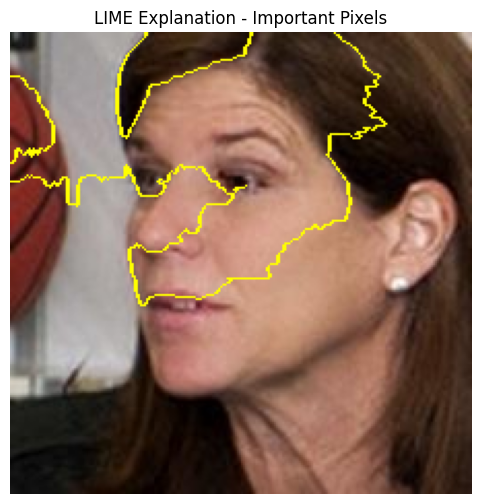

In [27]:
# Get Explanation for the Predicted Class
top_class = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(top_class, positive_only=True, num_features=5, hide_rest=False)

# Show Explanation
plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation - Important Pixels")
plt.axis("off")
plt.show()
